In [241]:
#import libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.linear_model import SGDClassifier
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, recall_score, f1_score
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from imblearn import over_sampling

In [192]:
#import features for modeling
features = pd.read_csv('Features.csv')

features.columns

Index(['Provider', 'Phys_Count', 'Patient_Count', 'Claim_Count',
       'Service_Type', 'Both_Service', 'Inpatient', 'Outpatient',
       'DuplicateClaims', 'Duplicate_Claims_Percent', 'AvgClaimDuration',
       'Avg_Cost', 'Avg_Age', 'Gender1', 'Gender2', 'Race1', 'Race2', 'Race3',
       'Race5', 'ChronicCond_Alzheimer', 'ChronicCond_KidneyDisease',
       'ChronicCond_Cancer', 'ChronicCond_ObstrPulmonary',
       'ChronicCond_Depression', 'ChronicCond_Diabetes',
       'ChronicCond_IschemicHeart', 'ChronicCond_Osteoporasis',
       'ChronicCond_rheumatoidarthritis', 'ChronicCond_stroke',
       'PotentialFraud', 'NetworkDegree', 'isFraudConnected',
       'NoPhysicianCount'],
      dtype='object')

In [193]:
features['PotentialFraud'] = features['PotentialFraud'].map({'No': 0, 'Yes': 1})
#features.set_index('Provider', inplace=True)

In [194]:
X = features.drop(['PotentialFraud', 'Service_Type','Provider'], axis=1)
y = features['PotentialFraud'] 

In [195]:
#train/test split 


In [198]:
#create seperate dataset with dummy variables to add back after scaling
non_num = X[['Both_Service', 'Inpatient', 'Outpatient',\
            'isFraudConnected']]

#drop dummy variables
X = X.drop(['Both_Service', 'Inpatient', 'Outpatient',\
           'isFraudConnected'], axis =1)

In [199]:
#scale on the training set 
scaler = RobustScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=(X.columns), index=X.index)
X_scaled.head()

,Phys_Count,Patient_Count,Claim_Count,DuplicateClaims,Duplicate_Claims_Percent,AvgClaimDuration,Avg_Cost,Avg_Age,Gender1,Gender2,...,ChronicCond_Cancer,ChronicCond_ObstrPulmonary,ChronicCond_Depression,ChronicCond_Diabetes,ChronicCond_IschemicHeart,ChronicCond_Osteoporasis,ChronicCond_rheumatoidarthritis,ChronicCond_stroke,NetworkDegree,NoPhysicianCount
0,2.208589,2.111111,1.833861,1.973958,-0.117647,-0.248722,-0.115209,-0.5,2.177606,2.080460,...,1.880482,1.867933,1.919836,1.897468,1.856867,1.793658,1.923621,1.859723,1.333333,2.0
1,-0.490798,0.222222,0.571203,1.098958,1.352941,-0.067768,0.139541,-1.5,0.308880,0.149425,...,0.623388,0.619477,0.583762,0.590488,0.523533,0.608613,0.607261,0.557749,-0.666667,2.0
2,-0.073620,-0.450980,-0.444620,-0.484375,-0.647059,1.419703,0.416436,-2.0,-0.416988,-0.494253,...,-0.427343,-0.440855,-0.448099,-0.447190,-0.435848,-0.423095,-0.445073,-0.438471,-0.666667,0.0
3,0.245399,-0.359477,-0.390823,-0.432292,-0.588235,0.898262,0.747762,0.5,-0.370656,-0.367816,...,-0.382631,-0.374347,-0.409044,-0.395306,-0.392005,-0.383341,-0.375295,-0.388072,-0.333333,0.0
4,-0.441718,1.941176,1.625000,1.578125,-0.411765,0.545887,0.396558,-0.5,2.270270,1.712644,...,1.631126,1.624703,1.667009,1.618283,1.673759,1.651680,1.604903,1.626207,-0.333333,1.0


In [200]:
#add back dummy variables to scaled dataset 
X_scaled = pd.concat((X_scaled, non_num), axis=1)
X_scaled.head(5)

,Phys_Count,Patient_Count,Claim_Count,DuplicateClaims,Duplicate_Claims_Percent,AvgClaimDuration,Avg_Cost,Avg_Age,Gender1,Gender2,...,ChronicCond_IschemicHeart,ChronicCond_Osteoporasis,ChronicCond_rheumatoidarthritis,ChronicCond_stroke,NetworkDegree,NoPhysicianCount,Both_Service,Inpatient,Outpatient,isFraudConnected
0,2.208589,2.111111,1.833861,1.973958,-0.117647,-0.248722,-0.115209,-0.5,2.177606,2.080460,...,1.856867,1.793658,1.923621,1.859723,1.333333,2.0,0,0,1,0.0
1,-0.490798,0.222222,0.571203,1.098958,1.352941,-0.067768,0.139541,-1.5,0.308880,0.149425,...,0.523533,0.608613,0.607261,0.557749,-0.666667,2.0,1,0,0,0.0
2,-0.073620,-0.450980,-0.444620,-0.484375,-0.647059,1.419703,0.416436,-2.0,-0.416988,-0.494253,...,-0.435848,-0.423095,-0.445073,-0.438471,-0.666667,0.0,1,0,0,0.0
3,0.245399,-0.359477,-0.390823,-0.432292,-0.588235,0.898262,0.747762,0.5,-0.370656,-0.367816,...,-0.392005,-0.383341,-0.375295,-0.388072,-0.333333,0.0,1,0,0,0.0
4,-0.441718,1.941176,1.625000,1.578125,-0.411765,0.545887,0.396558,-0.5,2.270270,1.712644,...,1.673759,1.651680,1.604903,1.626207,-0.333333,1.0,1,0,0,0.0


In [201]:
#use as cv=skf, ensures results are consistent in each partition
s_kf = StratifiedKFold(n_splits=5, random_state=42, shuffle=True);
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42, stratify=y)

### Logistic Regression

In [202]:
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
import sklearn.model_selection as ms
plt.style.use('ggplot')

In [257]:
logistic = LogisticRegression(C=0.237, solver = 'liblinear',penalty='l2')
logistic.fit(X_train, y_train)
logistic.score(X_test, y_test)
recall_score(y_test,logistic.predict(X_test))
#confusion_matrix(y_test,logistic.predict(X_test))

0.8275862068965517

In [251]:
grid_para_logit = {
    'C': np.linspace(0,1.5,20)
}
grid_search_logit = ms.GridSearchCV(logistic, grid_para_logit, cv=5, scoring='recall', n_jobs=-1)
%time grid_search_logit.fit(X_train, y_train)

CPU times: user 440 ms, sys: 72.6 ms, total: 512 ms
Wall time: 2.69 s


GridSearchCV(cv=5, estimator=LogisticRegression(C=0.316, solver='liblinear'),
             n_jobs=-1,
             param_grid={'C': array([0.        , 0.07894737, 0.15789474, 0.23684211, 0.31578947,
       0.39473684, 0.47368421, 0.55263158, 0.63157895, 0.71052632,
       0.78947368, 0.86842105, 0.94736842, 1.02631579, 1.10526316,
       1.18421053, 1.26315789, 1.34210526, 1.42105263, 1.5       ])},
             scoring='recall')

In [252]:
print(grid_search_logit.best_params_)
print(grid_search_logit.best_score_)
logistic_final = grid_search_logit.best_estimator_
X_scaled.columns

{'C': 0.23684210526315788}
0.8837187789084181


Index(['Phys_Count', 'Patient_Count', 'Claim_Count', 'DuplicateClaims',
       'Duplicate_Claims_Percent', 'AvgClaimDuration', 'Avg_Cost', 'Avg_Age',
       'Gender1', 'Gender2', 'Race1', 'Race2', 'Race3', 'Race5',
       'ChronicCond_Alzheimer', 'ChronicCond_KidneyDisease',
       'ChronicCond_Cancer', 'ChronicCond_ObstrPulmonary',
       'ChronicCond_Depression', 'ChronicCond_Diabetes',
       'ChronicCond_IschemicHeart', 'ChronicCond_Osteoporasis',
       'ChronicCond_rheumatoidarthritis', 'ChronicCond_stroke',
       'NetworkDegree', 'NoPhysicianCount', 'Both_Service', 'Inpatient',
       'Outpatient', 'isFraudConnected'],
      dtype='object')

Feature: Phys_Count , Score: 0.08431
Feature: Patient_Count , Score: 0.00460
Feature: Claim_Count , Score: 0.18510
Feature: DuplicateClaims , Score: 0.35904
Feature: Duplicate_Claims_Percent , Score: 0.21083
Feature: AvgClaimDuration , Score: 0.06444
Feature: Avg_Cost , Score: 0.42990
Feature: Avg_Age , Score: 0.03485
Feature: Gender1 , Score: 0.12193
Feature: Gender2 , Score: 0.11257
Feature: Race1 , Score: 0.02107
Feature: Race2 , Score: 0.05978
Feature: Race3 , Score: 0.03976
Feature: Race5 , Score: 0.03256
Feature: ChronicCond_Alzheimer , Score: 0.17344
Feature: ChronicCond_KidneyDisease , Score: 0.02786
Feature: ChronicCond_Cancer , Score: 0.15863
Feature: ChronicCond_ObstrPulmonary , Score: 0.05933
Feature: ChronicCond_Depression , Score: 0.14629
Feature: ChronicCond_Diabetes , Score: 0.07805
Feature: ChronicCond_IschemicHeart , Score: 0.02528
Feature: ChronicCond_Osteoporasis , Score: 0.00243
Feature: ChronicCond_rheumatoidarthritis , Score: 0.14086
Feature: ChronicCond_stroke ,

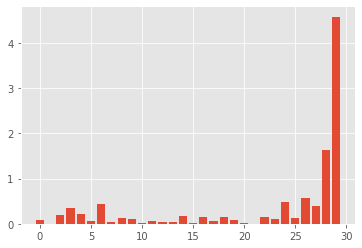

In [213]:
importance = logistic_final.coef_[0]
# summarize feature importance
for i,v in enumerate(importance):
	print('Feature:', X_scaled.columns[i],', Score: %.5f' % (np.abs(v)))
# plot feature importance
          
plt.bar([x for x in range(len(importance))], np.abs(importance))
plt.show()

In [215]:
# importance in order
pd.Series(np.abs(importance), index=X_scaled.columns).sort_values(ascending=False)

isFraudConnected                   4.582467
Outpatient                         1.630079
Both_Service                       0.576820
NetworkDegree                      0.478362
Avg_Cost                           0.429897
Inpatient                          0.395331
DuplicateClaims                    0.359037
Duplicate_Claims_Percent           0.210831
Claim_Count                        0.185101
ChronicCond_Alzheimer              0.173441
ChronicCond_Cancer                 0.158633
ChronicCond_Depression             0.146286
ChronicCond_rheumatoidarthritis    0.140862
NoPhysicianCount                   0.129206
Gender1                            0.121926
Gender2                            0.112568
ChronicCond_stroke                 0.098673
Phys_Count                         0.084308
ChronicCond_Diabetes               0.078049
AvgClaimDuration                   0.064441
Race2                              0.059778
ChronicCond_ObstrPulmonary         0.059327
Race3                           

In [54]:
# Correlation Matrix 
corr = features.corr().abs()
corr.style.background_gradient(cmap='coolwarm')

,Phys_Count,Patient_Count,Claim_Count,Both_Service,Inpatient,Outpatient,DuplicateClaims,Duplicate_Claims_Percent,AvgClaimDuration,Avg_Cost,Avg_Age,Gender1,Gender2,Race1,Race2,Race3,Race5,ChronicCond_Alzheimer,ChronicCond_KidneyDisease,ChronicCond_Cancer,ChronicCond_ObstrPulmonary,ChronicCond_Depression,ChronicCond_Diabetes,ChronicCond_IschemicHeart,ChronicCond_Osteoporasis,ChronicCond_rheumatoidarthritis,ChronicCond_stroke,PotentialFraud,NetworkDegree,isFraudConnected,NoPhysicianCount
Phys_Count,1.000000,0.384567,0.209319,0.248152,0.066006,0.236413,0.250841,0.108740,0.035263,0.048678,0.015180,0.385037,0.383008,0.390418,0.378383,0.144380,0.181182,0.208266,0.207238,0.208960,0.206986,0.208694,0.207699,0.207530,0.208548,0.208812,0.209385,0.199890,0.564411,0.275333,0.131213
Patient_Count,0.384567,1.000000,0.946559,0.008841,0.055238,0.001127,0.927216,0.093066,0.082485,0.103278,0.024236,0.997551,0.998661,0.996267,0.858958,0.680021,0.692500,0.946708,0.945466,0.946904,0.945438,0.946421,0.946478,0.945407,0.945995,0.946425,0.946477,0.395636,0.109747,0.268150,0.753859
Claim_Count,0.209319,0.946559,1.000000,0.018963,0.045696,0.027228,0.967189,0.096760,0.099968,0.126959,0.011231,0.944165,0.945348,0.939714,0.771102,0.716160,0.718252,0.999777,0.999736,0.999929,0.999762,0.999797,0.999797,0.999758,0.999859,0.999861,0.999937,0.378776,0.023593,0.231674,0.840127
Both_Service,0.248152,0.008841,0.018963,1.000000,0.094221,0.983709,0.009379,0.025536,0.373727,0.465319,0.018036,0.010407,0.007656,0.008597,0.013360,0.000847,0.006670,0.021500,0.023735,0.019608,0.022851,0.019524,0.022345,0.022561,0.019404,0.020470,0.019957,0.318173,0.244497,0.345168,0.012461
Inpatient,0.066006,0.055238,0.045696,0.094221,1.000000,0.086285,0.044971,0.020598,0.336833,0.410186,0.065048,0.055596,0.054799,0.055603,0.048743,0.032661,0.030798,0.046014,0.046364,0.045784,0.046035,0.045920,0.046224,0.045969,0.045658,0.046098,0.045825,0.052668,0.077189,0.041127,0.037084
Outpatient,0.236413,0.001127,0.027228,0.983709,0.086285,1.000000,0.017506,0.029274,0.434821,0.539724,0.006303,0.000376,0.002234,0.001437,0.004568,0.006745,0.001114,0.029825,0.032125,0.027890,0.031180,0.027830,0.030708,0.030878,0.027663,0.028809,0.028247,0.327913,0.230735,0.337991,0.019167
DuplicateClaims,0.250841,0.927216,0.967189,0.009379,0.044971,0.017506,1.000000,0.055468,0.092805,0.118094,0.009316,0.922376,0.927874,0.924518,0.770413,0.645991,0.674168,0.966735,0.967008,0.966935,0.966548,0.967048,0.966075,0.965763,0.967246,0.967015,0.966516,0.350021,0.049174,0.226666,0.789048
Duplicate_Claims_Percent,0.108740,0.093066,0.096760,0.025536,0.020598,0.029274,0.055468,1.000000,0.055112,0.041501,0.012086,0.097613,0.089410,0.090961,0.077811,0.100676,0.038223,0.097723,0.097393,0.097755,0.097821,0.097633,0.099122,0.098745,0.096578,0.097415,0.097414,0.105001,0.088602,0.040126,0.124905
AvgClaimDuration,0.035263,0.082485,0.099968,0.373727,0.336833,0.434821,0.092805,0.055112,1.000000,0.795650,0.054144,0.079990,0.084070,0.084503,0.069247,0.040220,0.039837,0.103219,0.105680,0.100990,0.104444,0.102047,0.103991,0.103830,0.100710,0.101672,0.101595,0.305476,0.017356,0.260882,0.078504
Avg_Cost,0.048678,0.103278,0.126959,0.465319,0.410186,0.539724,0.118094,0.041501,0.795650,1.000000,0.071142,0.100905,0.104709,0.105123,0.089510,0.051343,0.054969,0.130430,0.133362,0.128309,0.132133,0.129466,0.131332,0.131309,0.127905,0.128947,0.128792,0.387022,0.027556,0.336498,0.102210


### Stochastic Gradient Descent Classifier

In [216]:
from sklearn.linear_model import SGDClassifier

In [258]:
sgd = SGDClassifier(loss='log', max_iter=1e4, l1_ratio=0, alpha=1e-4, shuffle=False)
grid_para_sgd = {
    'max_iter': [0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000],
    'alpha': np.linspace(5e-4,1e-4,30)
}
grid_search_sgd = ms.GridSearchCV(sgd, grid_para_sgd, cv=5, scoring='recall', n_jobs=-1)
%time grid_search_sgd.fit(X_train, y_train)

CPU times: user 1.89 s, sys: 36.2 ms, total: 1.92 s
Wall time: 3.85 s


GridSearchCV(cv=5,
             estimator=SGDClassifier(l1_ratio=0, loss='log', max_iter=10000.0,
                                     shuffle=False),
             n_jobs=-1,
             param_grid={'alpha': array([0.0005    , 0.00048621, 0.00047241, 0.00045862, 0.00044483,
       0.00043103, 0.00041724, 0.00040345, 0.00038966, 0.00037586,
       0.00036207, 0.00034828, 0.00033448, 0.00032069, 0.0003069 ,
       0.0002931 , 0.00027931, 0.00026552, 0.00025172, 0.00023793,
       0.00022414, 0.00021034, 0.00019655, 0.00018276, 0.00016897,
       0.00015517, 0.00014138, 0.00012759, 0.00011379, 0.0001    ]),
                         'max_iter': [0.001, 0.01, 0.1, 1, 10, 100, 1000,
                                      10000]},
             scoring='recall')

In [260]:
print(grid_search_sgd.best_params_)
print(grid_search_sgd.best_score_)
sgd_final = grid_search_sgd.best_estimator_
sgd.set_params(max_iter=1000,alpha=3.5e-4)
sgd.fit(X_train,y_train)
sgd.score(X_test,y_test)
recall_score(y_test,sgd.predict(X_test))

{'alpha': 0.0003068965517241379, 'max_iter': 1000}
0.9180388529139686


0.8620689655172413

Feature: Phys_Count , Score: 0.99036
Feature: Patient_Count , Score: 0.17691
Feature: Claim_Count , Score: 0.41613
Feature: DuplicateClaims , Score: 0.27461
Feature: Duplicate_Claims_Percent , Score: 1.87428
Feature: AvgClaimDuration , Score: 0.12101
Feature: Avg_Cost , Score: 2.15539
Feature: Avg_Age , Score: 0.48951
Feature: Gender1 , Score: 1.18292
Feature: Gender2 , Score: 0.88795
Feature: Race1 , Score: 0.42294
Feature: Race2 , Score: 0.17342
Feature: Race3 , Score: 0.12422
Feature: Race5 , Score: 0.23634
Feature: ChronicCond_Alzheimer , Score: 0.46638
Feature: ChronicCond_KidneyDisease , Score: 0.38227
Feature: ChronicCond_Cancer , Score: 1.21764
Feature: ChronicCond_ObstrPulmonary , Score: 0.29914
Feature: ChronicCond_Depression , Score: 0.79742
Feature: ChronicCond_Diabetes , Score: 0.27245
Feature: ChronicCond_IschemicHeart , Score: 0.23424
Feature: ChronicCond_Osteoporasis , Score: 1.19940
Feature: ChronicCond_rheumatoidarthritis , Score: 0.81322
Feature: ChronicCond_stroke ,

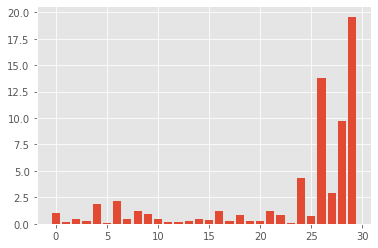

In [261]:
importance = sgd_final.coef_[0]
# summarize feature importance
for i,v in enumerate(importance):
	print('Feature:', X_scaled.columns[i],', Score: %.5f' % (np.abs(v)))
pd.Series(np.abs(importance), index=X_scaled.columns).sort_values(ascending=False)
# plot feature importance
          
plt.bar([x for x in range(len(importance))], np.abs(importance))
plt.show()

In [262]:
pd.Series(np.abs(importance), index=X_scaled.columns).sort_values(ascending=False)

isFraudConnected                   19.582574
Both_Service                       13.790103
Outpatient                          9.745586
NetworkDegree                       4.300086
Inpatient                           2.873674
Avg_Cost                            2.155387
Duplicate_Claims_Percent            1.874278
ChronicCond_Cancer                  1.217638
ChronicCond_Osteoporasis            1.199405
Gender1                             1.182922
Phys_Count                          0.990360
Gender2                             0.887946
ChronicCond_rheumatoidarthritis     0.813216
ChronicCond_Depression              0.797418
NoPhysicianCount                    0.754851
Avg_Age                             0.489508
ChronicCond_Alzheimer               0.466380
Race1                               0.422944
Claim_Count                         0.416126
ChronicCond_KidneyDisease           0.382271
ChronicCond_ObstrPulmonary          0.299138
DuplicateClaims                     0.274609
ChronicCon

### K-Nearest Neighbors

In [263]:
knn = KNeighborsClassifier()
knn.fit(X_train, y_train)
knn.score(X_test, y_test)

0.8773234200743495

In [264]:
#upsampling for KNN 
oversample = over_sampling.SMOTE()
X_train_knn, y_train_knn = oversample.fit_resample(X_train, y_train)

y_train_knn.value_counts()

1    841
0    841
Name: PotentialFraud, dtype: int64

In [265]:
# baseline recall score
knn_train_recall = recall_score(y_train_knn, knn.predict(X_train_knn))
knn_test_recall = recall_score(y_test, knn.predict(X_test))

print('Train Set Recall Score:', knn_train_recall)
print('Test Set Recall Score:', knn_test_recall)

Train Set Recall Score: 0.8026159334126041
Test Set Recall Score: 0.5689655172413793


In [266]:
# grid search
params = {'n_neighbors': np.arange(0,10)+70}

knn_GS =  GridSearchCV(knn, param_grid = params,
                       cv=s_kf, n_jobs=(-1), verbose = 1,
                       return_train_score = True,
                       scoring = 'recall')

knn_GS.fit(X_train_knn, y_train_knn)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    2.1s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    2.8s finished


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=KNeighborsClassifier(), n_jobs=-1,
             param_grid={'n_neighbors': array([70, 71, 72, 73, 74, 75, 76, 77, 78, 79])},
             return_train_score=True, scoring='recall', verbose=1)

In [267]:
print(knn_GS.best_params_)
print(knn_GS.best_score_)
best_knn = knn_GS.best_estimator_

{'n_neighbors': 77}
0.942920540997464


In [268]:
# new score
bestknn_train_recall = recall_score(y_train_knn, best_knn.predict(X_train_knn))
bestknn_test_recall  = recall_score(y_test, best_knn.predict(X_test))

print('Train Set Recall Score:', bestknn_train_recall)
print('Test Set Recall Score:', bestknn_test_recall)

Train Set Recall Score: 0.9453032104637337
Test Set Recall Score: 0.8275862068965517


In [269]:
confusion_matrix(y_train_knn, best_knn.predict(X_train_knn))

array([[673, 168],
       [ 46, 795]])

### Support Vector Machine

In [ ]:
svm = SVC(class_weight='balanced')
svm.fit(X_train, y_train)
svm.fit(X_test, y_test)

In [ ]:
# baseline score
svm_train_recall = recall_score(y_train, svm.predict(X_train))
svm_test_recall = recall_score(y_test, svm.predict(X_test))

print('Train Set Recall Score:', svm_train_recall)
print('Test Set Recall Score:', svm_test_recall)

In [ ]:
# grid search 
# params = {'C':np.logspace(-1,2,60), 
#           'kernel': ('linear', 'poly', 'rbf'),
#           'gamma':('auto', 'scale'),
#           'degree': [1,3,5]}

In [ ]:
# grid search 
params = {'C':np.logspace(-1,2,60), 
          'kernel': ['linear'],
          'gamma':('auto', 'scale')}

svm_GS =  GridSearchCV(svm, params, cv=s_kf, n_jobs=(-1), verbose = 1, return_train_score = True, scoring = 'recall')
svm_GS.fit(X_train, y_train)

In [ ]:
svm_index =  svm_GS.support_ #index of support vector
print('Index of support vector:' + str(svm_index))

support = svm_GS.support_vectors_ #value of support vector
print(support)

In [ ]:
print(svm_GS.best_params_)
print(svm_GS.best_score_)

In [ ]:
best_svm = svm_GS.best_estimator_

bestsvm_train_recall = recall_score(y_train, bestsvm.predict(X_train))
bestsvm_test_recall = recall_score(y_test, bestsvm.predict(X_test))

print('Train Set Recall Score:', bestsvm_train_recall)
print('Test Set Recall Score:', bestsvm_test_recall)

In [ ]:
#recall = TP / (TP+FN) 
confusion_matrix(y_train, best_svm.predict(X_train))





In [273]:
from sklearn import discriminant_analysis

#### Your code here, name your model object LDA
LDA = discriminant_analysis.LinearDiscriminantAnalysis()
LDA.fit(X_train, y_train)

LinearDiscriminantAnalysis()

In [274]:
y_predict = LDA.predict(X_test)
recall_score(y_test,y_predict)

0.7068965517241379

In [275]:
QDA = discriminant_analysis.QuadraticDiscriminantAnalysis(reg_param=1)
QDA.fit(X_train_knn, y_train_knn)
y_predict = QDA.predict(X_test)
recall_score(y_test,y_predict)

/home/truong/anaconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


0.43103448275862066